<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Long_Term_Analysis_of_Equities_and_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

14:13:03 Starting...
14:13:03 Installing yfinance into Google notebook...
14:13:11 Installing arch into Google notebook...
14:13:22 Initialized.


/tmp/ipython-input-2333949891.py:2: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  gold.index=pd.DatetimeIndex(gold.index).to_period('B')


,Close
,XAU
Date,
1968-04-01,37.70
1968-04-02,37.30
1968-04-03,37.60
1968-04-04,36.95
1968-04-05,37.00
...,...
2026-01-29,5405.00
2026-01-30,4981.85


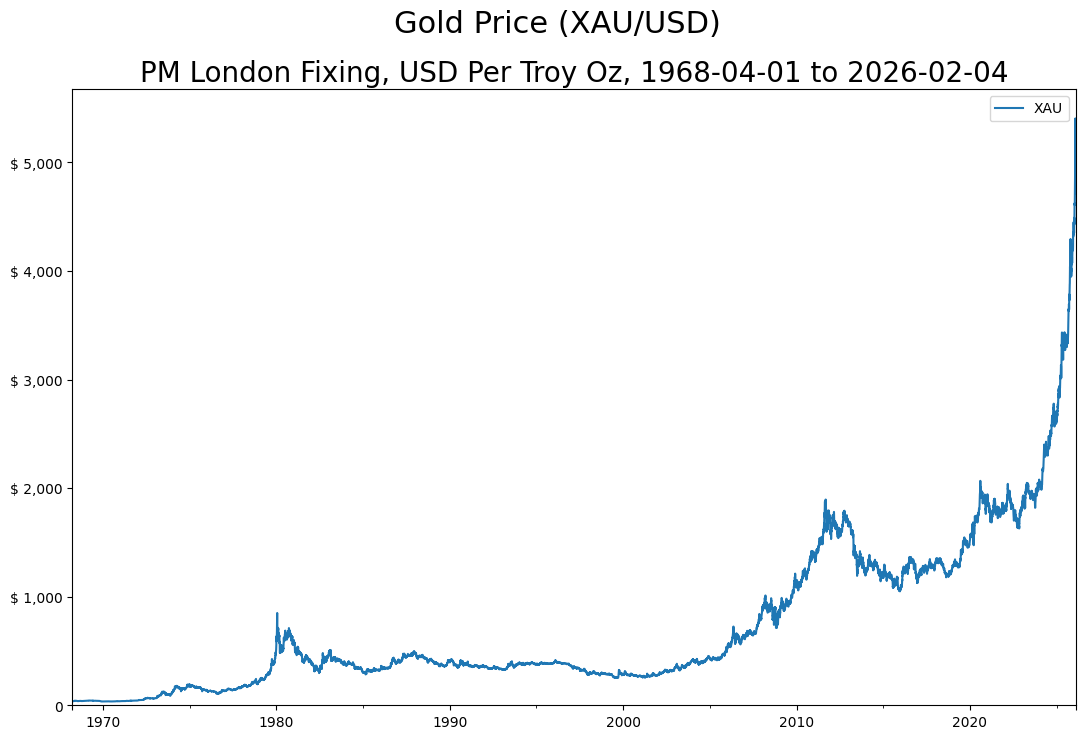

In [3]:
gold=pd.read_json(url:="https://prices.lbma.org.uk/json/gold_pm.json")[["d","v"]].set_index("d")
nprint("Read gold prices from %s." % url)
gold.index=pd.DatetimeIndex(gold.index).to_period('B')
gold.index.name='Date'
gold[('Close',alternative:='XAU')]=gold['v'].apply(lambda x:x[0])
gold.drop('v',axis=1,inplace=True)
gold.columns=pd.MultiIndex.from_tuples(gold.columns)
display(gold)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
gold['Close'].plot(ax=plot)
figure.suptitle(title:='Gold Price (XAU/USD)',fontsize=22)
plot.set_title(subtitle:='PM London Fixing, USD Per Troy Oz, %s to %s' % (gold.index[0],gold.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title.replace("/","-")+".png",dpi=300,bbox_inches='tight')

You need to enter a FRED API key (your keys are stored here: https://fredaccount.stlouisfed.org/apikeys): ··········


/tmp/ipython-input-54619090.py:8: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  bills.index=bills.index.to_timestamp().to_period('B')


,Discount Rate,Days,Return,Close
,DTB3,,,DTB3
Date,,,,
1954-01-04,1.33,0,NaN,1000.000000
1954-01-05,1.28,1,0.003694,1000.036944
1954-01-06,1.28,2,0.003556,1000.072501
1954-01-07,1.31,3,0.003556,1000.108059
1954-01-08,1.31,4,0.003639,1000.144452
...,...,...,...,...
2026-01-28,3.59,26322,0.009944,21482.835894
2026-01-29,3.59,26323,0.009972,21484.978210


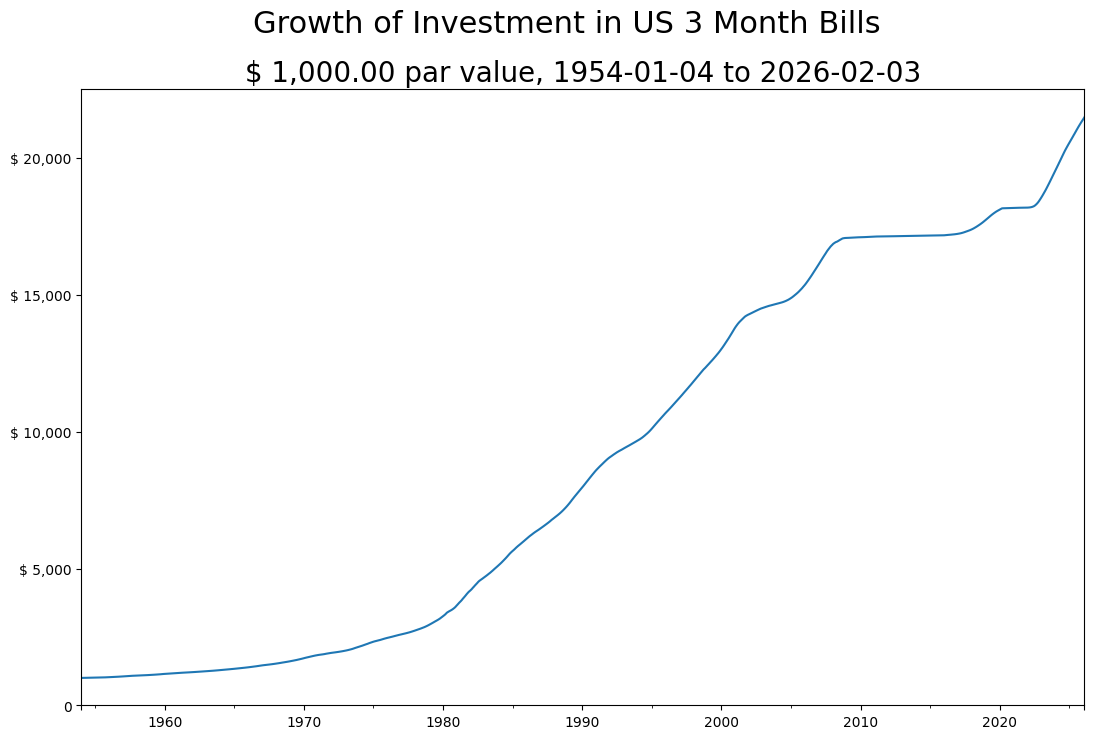

In [4]:
bills=get_fred(n:='DTB3')[0]
nprint("Read Three Month Bills Rate from FRED.")
bills.index.name='Date'
bills.columns=pd.MultiIndex.from_tuples([('Discount Rate',n)])
bills['Days']=list(map(lambda x:(x-bills.index[0]).n,bills.index))
bills['Return']=bills[('Discount Rate',n)].shift()/360e0*bills['Days'].diff()
bills[('Close',n)]=(par:=1e3)*(one+bills['Return']/hundred).cumprod()
bills.loc[bills.index[0],('Close',n)]=par
bills.index=bills.index.to_timestamp().to_period('B')
display(bills)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
bills[('Close',n)].plot(ax=plot)
figure.suptitle(title:='Growth of Investment in US 3 Month Bills',fontsize=22)
plot.set_title(subtitle:='$ {:,.2f} par value, {:s} to {:s}'.format(par,str(bills.index[0]),str(bills.index[-1])),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1555988758.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.DatetimeIndex(data.index).to_period('B')
/tmp/ipython-input-1555988758.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred


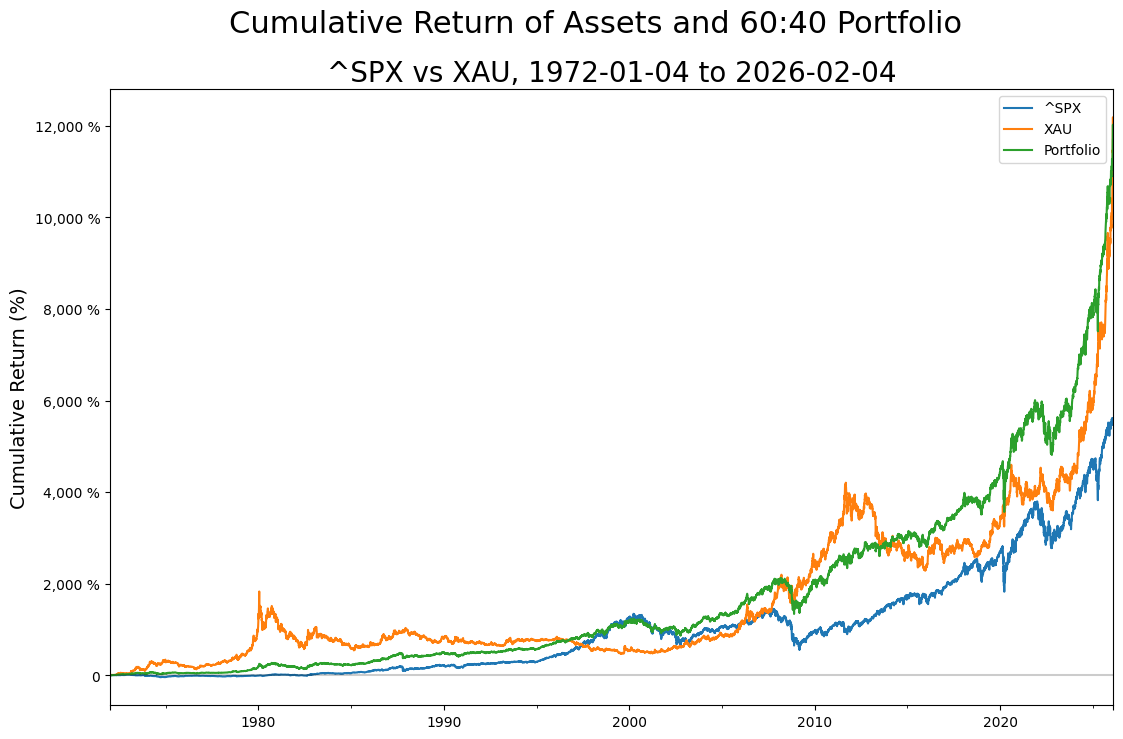

In [23]:
data=download(market:='^GSPC',"1972-01-01",today("%Y-%m-%d"),auto_adjust=True)
nprint("Read %s data from Yahoo Finance." % market)
tickers=[market,alternative:='XAU']
data.index=pd.DatetimeIndex(data.index).to_period('B')
data[('Close',alternative)]=gold[('Close',alternative)] if alternative=='XAU' else bills[('Close',alternative)]
data.columns=pd.MultiIndex.from_tuples(data.columns)
#data=data.resample('M').last()

for ticker in tickers:
    data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred
    data[('Weight',ticker)]=0.6 if ticker==market else 0.4

data.dropna(inplace=True)
data.sort_index(axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

for ticker in tickers+['Portfolio']:
    data[('Cumulative',ticker)]=(data[('Return',ticker)]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and 60:40 Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [24]:
from warnings import filterwarnings ; filterwarnings('ignore',category=pd.errors.PerformanceWarning)

report=pd.DataFrame({'Weight':np.arange(zero,one+(delta:=0.01),delta)}).set_index("Weight")

if data.index.dtype==pd.PeriodDtype('W'):
    annualize=52e0

elif data.index.dtype==pd.PeriodDtype('M'):
    annualize=12e0

elif data.index.dtype==pd.PeriodDtype('Q'):
    annualize=4e0

elif data.index.dtype==pd.PeriodDtype('Y'):
    annualize=1e0

else:
    annualize=252e0

nprint("Finding optimal portfolio by brute-force scan.")

for weight in tqdm(report.index):
    report.loc[weight,market]=weight
    report.loc[weight,alternative]=one-weight

    for ticker in tickers:
        data[('Weight',ticker)]=report.loc[weight,ticker]

    data.drop(('Return','Portfolio'),axis=1,inplace=True)
    data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

    report.loc[weight,'Sample']=(r:=data[('Return','Portfolio')]).count()
    report.loc[weight,'Mean']=(m:=r.mean())
    report.loc[weight,'Std.Dev.']=(s:=r.std())
    report.loc[weight,'Std.Err.']=r.sem()
    report.loc[weight,'Kurtosis']=r.kurt()+three

report['Sharpe']=report['Mean']/report['Std.Dev.']*annualize**half
report['Sharpe S.E.']=((annualize/report['Sample'])*(one+(report['Kurtosis']-one)/four*report['Sharpe']**two))**half
report['Annualized']=hundred*(one+report['Mean']/hundred)**annualize-hundred

display(report)

  0%|          | 0/101 [00:00<?, ?it/s]

,^SPX,XAU,Sample,Mean,Std.Dev.,Std.Err.,Kurtosis,Sharpe,Sharpe S.E.,Annualized
Weight,,,,,,,,,,
0.00,0.00,1.00,13307.0,0.043422,1.255948,0.010888,13.323665,0.548831,0.191080,11.560827
0.01,0.01,0.99,13307.0,0.043351,1.243319,0.010778,13.329784,0.553497,0.191887,11.540828
0.02,0.02,0.98,13307.0,0.043280,1.230788,0.010669,13.334209,0.558214,0.192700,11.520833
0.03,0.03,0.97,13307.0,0.043209,1.218358,0.010562,13.336815,0.562982,0.193518,11.500841
0.04,0.04,0.96,13307.0,0.043137,1.206032,0.010455,13.337474,0.567799,0.194341,11.480853
...,...,...,...,...,...,...,...,...,...,...
0.96,0.96,0.04,13307.0,0.036589,1.049580,0.009099,21.585225,0.553400,0.220871,9.657115
0.97,0.97,0.03,13307.0,0.036518,1.060108,0.009190,21.648224,0.546838,0.219476,9.637455
0.98,0.98,0.02,13307.0,0.036447,1.070794,0.009283,21.701835,0.540326,0.218063,9.617800


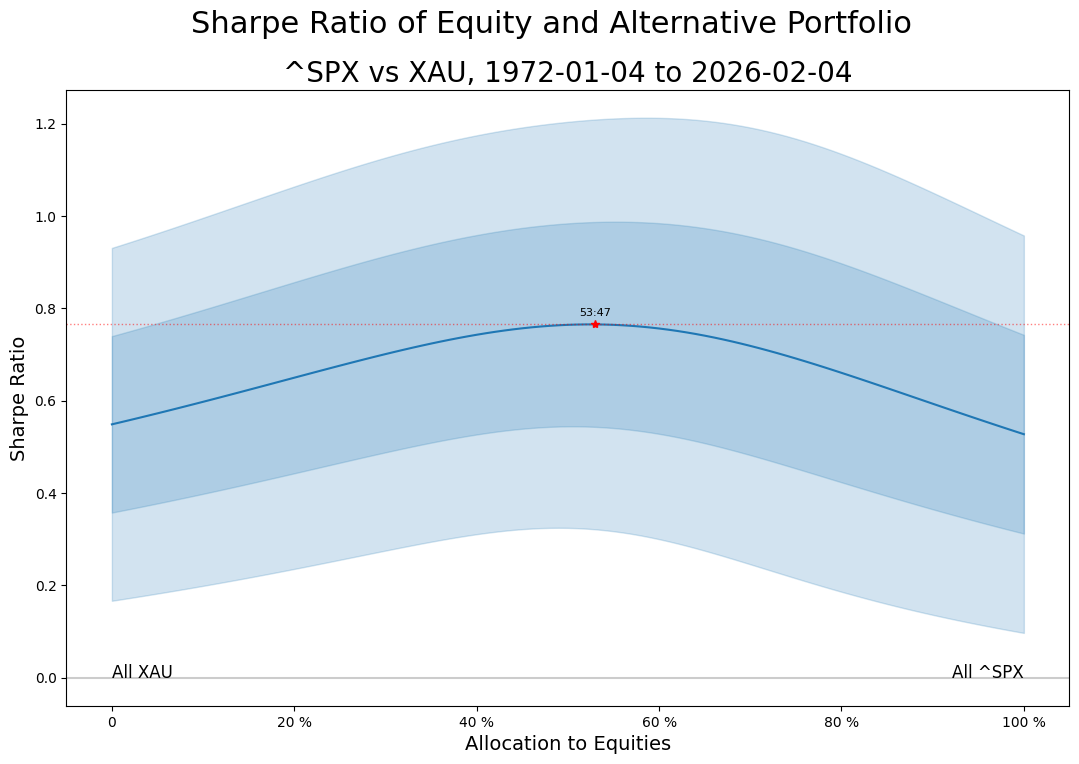

In [25]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index)*hundred,y:=report.loc[x,'Sharpe'])
plot.fill_between(x*hundred,y+(ye:=report.loc[x,'Sharpe S.E.']),y-ye,color='C0',alpha=0.2)
plot.fill_between(x*hundred,y+two*ye,y-two*ye,color='C0',alpha=0.2)
figure.suptitle(title:='Sharpe Ratio of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Sharpe Ratio',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[y.argmax()]*hundred,y.max(),'r*')
plot.text(x[y.argmax()]*hundred,y.max()*1.02,'%.0f:%.0f' % (x[y.argmax()]*hundred,hundred-x[y.argmax()]*hundred),fontsize=8,ha='center',va='bottom')
plot.axhline(y.max(),color='red',linestyle=':',linewidth=1,alpha=0.5)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

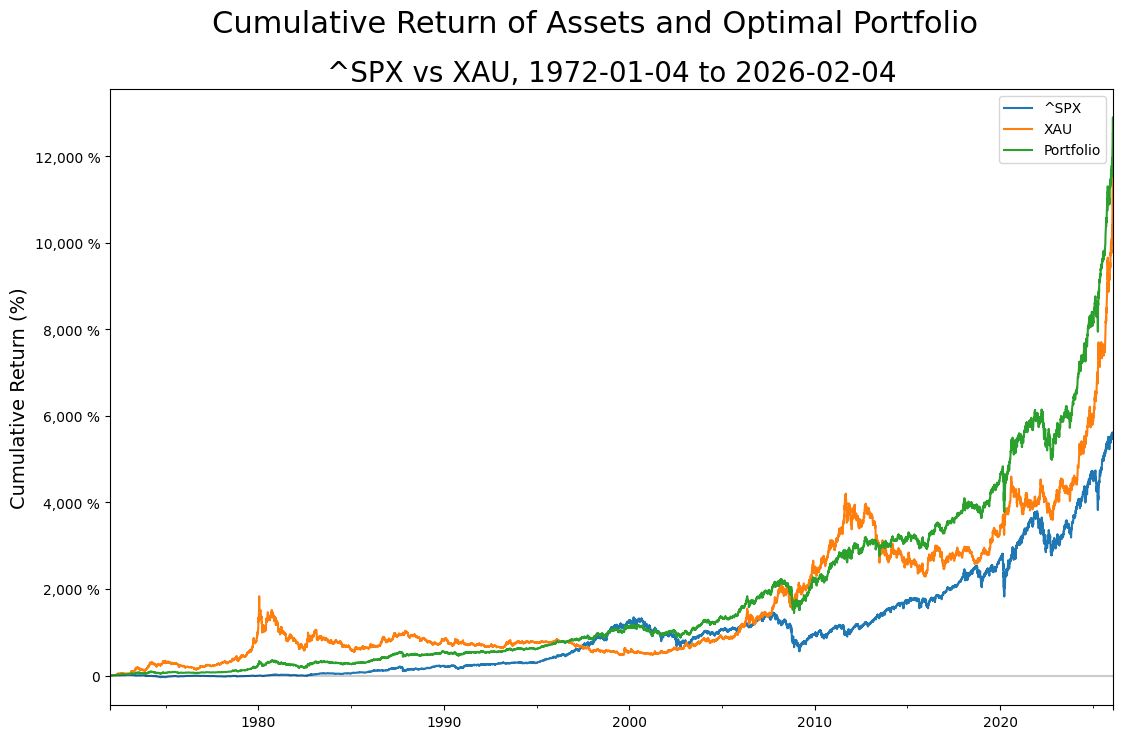

In [26]:
weight=x[y.argmax()]

for ticker in tickers:
    data[('Weight',ticker)]=report.loc[weight,ticker]

data.drop(('Return','Portfolio'),axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)
data[('Cumulative','Portfolio')]=(data[('Return','Portfolio')]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and Optimal Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

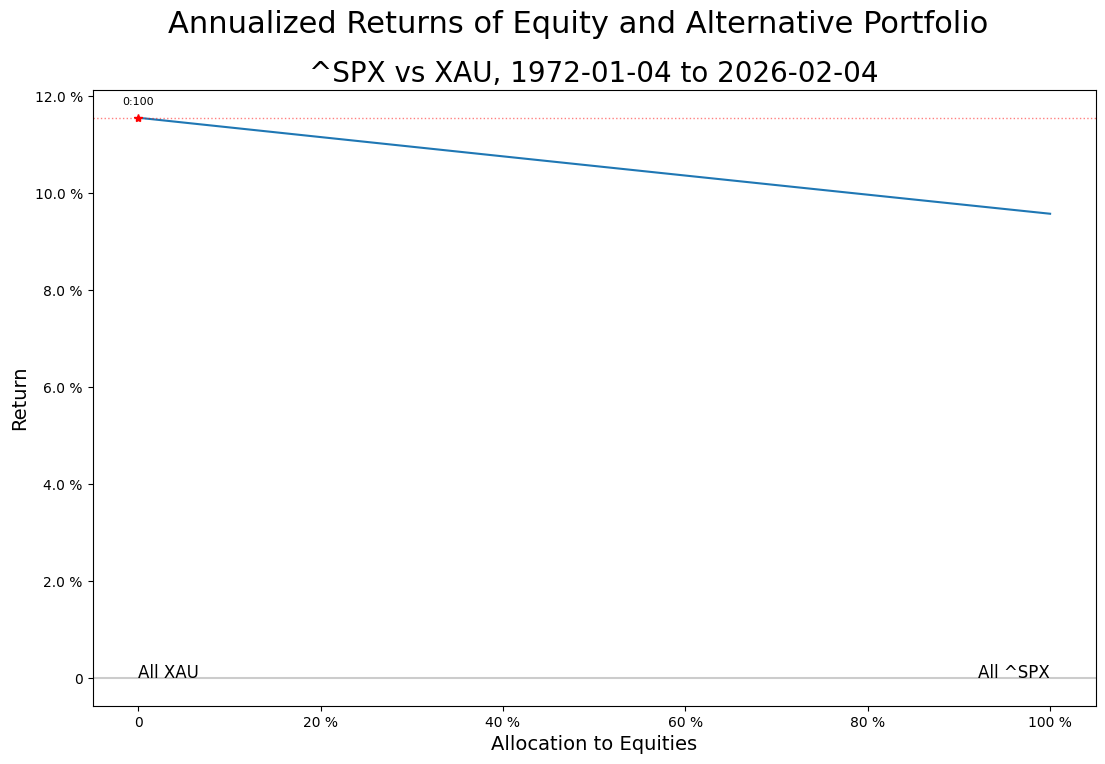

In [27]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index)*hundred,y:=report.loc[x,'Annualized'])
figure.suptitle(title:='Annualized Returns of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Return',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(1))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[y.argmax()]*hundred,y.max(),'r*')
plot.text(x[y.argmax()]*hundred,y.max()*1.02,'%.0f:%.0f' % (x[y.argmax()]*hundred,hundred-x[y.argmax()]*hundred),fontsize=8,ha='center',va='bottom')
plot.axhline(y.max(),color='red',linestyle=':',linewidth=1,alpha=0.5)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')